<a href="https://colab.research.google.com/github/AHamamd150/Zewail-city/blob/main/Generate_AnimeFaces_GAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm 
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
from keras import backend as K # The backend is important while we are dealing with keras layers and the basic low level operation cannot be handeled by numpy
from keras.losses import mse, binary_crossentropy,CategoricalCrossentropy
import os
import glob
import cv2 as CV
from sklearn.preprocessing import MinMaxScaler

# Prepare the training data set

In [2]:
!git clone https://github.com/AHamamd150/Zewail-city.git

Cloning into 'Zewail-city'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 141 (delta 67), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (141/141), 27.71 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [3]:
os.system('unzip Zewail-city/data/Anime_images.zip');

# Read all images in OpenCV with gray scale and resize them to have 28*28 dimensions 

In [4]:
data=glob.glob('Anime_images/*')
files=[]
for q in data:
  x1=CV.imread(q,0)
  x1=CV.resize(x1,(56,56))
  files.append(x1)

# Check some of the transformed images

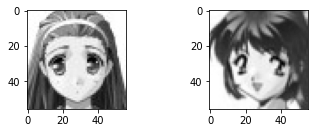

In [5]:
plt.subplot(221)
plt.imshow(files[0],cmap='gray');
plt.subplot(222)
plt.imshow(files[10],cmap='gray');

# Split into train and test samples

In [6]:
x_train= files[:450]
x_test = files[450:]


# Normalize the images


In [7]:
Scaler = MinMaxScaler()
x_train_transform,x_test_transform=[],[]
for q in range(len(x_train)):
    x_train_transform.append(Scaler.fit_transform(x_train[q]))
for q in range(len(x_test)):
    x_test_transform.append(Scaler.fit_transform(x_test[q]))


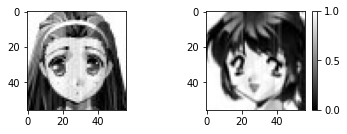

In [8]:
plt.subplot(221)
plt.imshow(x_train_transform[0].reshape(56,56),cmap='gray');
plt.subplot(222)
plt.imshow(x_train_transform[10].reshape(56,56),cmap='gray');
plt.colorbar();


In [9]:
x_train_transform = np.array(x_train_transform).reshape(-1,56,56,1)
x_test_transform = np.array(x_test_transform).reshape(-1,56,56,1)

# Define the GAE model 

In [13]:
# Sampling the latent variable z from the mean and std of the last dense layer 
def my_activation(x):
  return K.maximum(0.1,x)
def sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def encoder():
    encoder1 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',name='layer1')(encoder_input)
    encoder2 = layers.MaxPooling2D((2,2),padding='same')(encoder1)
    encoder3 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',name='layer2')(encoder2)
    encoder4 = layers.MaxPooling2D((2,2),padding='same')(encoder3)
    encoder5 = layers.Conv2D(8,kernel_size=2,activation='relu',padding='same',name='layer3')(encoder4)
    encoder6 = layers.MaxPooling2D((2,2),padding='same')(encoder5)
    encoder7 = layers.Conv2D(8,kernel_size=2,activation='relu',padding='same',name='layer4')(encoder6)
    encoder8 = layers.Flatten()(encoder7)
    encoder_output = layers.Dense(decoder_inputdim,activation='relu',name='layer5')(encoder8)
    z_mean = layers.Dense(latent, name='z_mean')(encoder_output)
    z_log_var = layers.Dense(latent, name='z_log_var')(encoder_output)
    z = layers.Lambda(sampling, output_shape=(latent,), name='z')([z_mean, z_log_var])
    encoder_model = Model(encoder_input, [z_mean, z_log_var, z])
    return encoder_model, z_mean, z_log_var



# define the decoder
def decoder():
    decoder_input = keras.Input(shape=(latent,))
    decoder1 = layers.Dense(392,activation='relu',name='layer5')(decoder_input)
    decoder2 = layers.Reshape((7,7,8))(decoder1) 
    decoder3 = layers.Conv2D(32,kernel_size=2,padding='same',activation='relu',name='layer6')(decoder2)
    decoder4 = layers.UpSampling2D((2,2))(decoder3)
    decoder5 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',name='layer7')(decoder4)
    decoder6 = layers.UpSampling2D((2,2))(decoder5)

    decoder7 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',name='layer8')(decoder6)
    decoder8 = layers.UpSampling2D((2,2))(decoder7)
    decoder_output = layers.Conv2D(1,kernel_size=2,padding='same',name='layer9')(decoder8)
    decoder_output = layers.Lambda(my_activation)(decoder_output)
    decoder_model= Model(decoder_input,decoder_output)
    return decoder_model


In [14]:
latent=4
decoder_inputdim=392 
encoder_input = keras.Input(shape=(56,56,1)) 
##########
encoder_model, z_mean, z_log_var = encoder() 
decoder_model = decoder() 
encoder_model.summary(),
decoder_model.summary();

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 56, 56, 1)]  0           []                               
                                                                                                  
 layer1 (Conv2D)                (None, 56, 56, 32)   160         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 28, 28, 32)  0           ['layer1[0][0]']                 
                                                                                                  
 layer2 (Conv2D)                (None, 28, 28, 32)   4128        ['max_pooling2d_3[0][0]']        
                                                                                            

In [15]:
outputs = decoder_model(encoder_model(encoder_input)[2]) 
VAE = Model(encoder_input,outputs,name='VAE') 

In [16]:
def Loss(inputs,output):
    inputs = K.flatten(inputs)
    output= K.flatten(outputs)
    reconstruction_loss = mse(inputs, output)
    reconstruction_loss *= decoder_inputdim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    VAE_loss =K.mean(reconstruction_loss + kl_loss)
    return VAE_loss

VAE.add_loss(Loss(encoder_input,outputs)) 

In [17]:
VAE.compile(optimizer='adam',loss=None)
h= VAE.fit(x_train_transform,epochs=50,batch_size=5 ,validation_data=(x_test_transform, None))

Epoch 1/50
90/90 [==============================] - 13s 19ms/step - loss: 54.6179 - val_loss: 40.0636
Epoch 2/50
90/90 [==============================] - 1s 13ms/step - loss: 36.7423 - val_loss: 37.3152
Epoch 3/50
90/90 [==============================] - 1s 12ms/step - loss: 35.1335 - val_loss: 35.1994
Epoch 4/50
90/90 [==============================] - 1s 13ms/step - loss: 34.3492 - val_loss: 34.3737
Epoch 5/50
90/90 [==============================] - 1s 12ms/step - loss: 33.7506 - val_loss: 34.0504
Epoch 6/50
90/90 [==============================] - 1s 12ms/step - loss: 33.2070 - val_loss: 33.3176
Epoch 7/50
90/90 [==============================] - 1s 12ms/step - loss: 32.6588 - val_loss: 32.5226
Epoch 8/50
90/90 [==============================] - 1s 13ms/step - loss: 31.5893 - val_loss: 32.4291
Epoch 9/50
90/90 [==============================] - 1s 12ms/step - loss: 31.1435 - val_loss: 30.9373
Epoch 10/50
90/90 [==============================] - 1s 12ms/step - loss: 31.0586 - val_lo

# check the latent space dimesions 

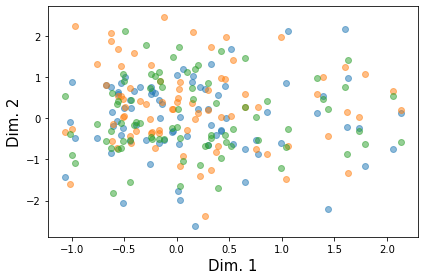

In [ ]:
z_mean, _, _ = encoder_model.predict(x_test_transform)

plt.scatter(z_mean[:, 0], z_mean[:, 1],cmap='RdBu_r',alpha=0.5);
plt.scatter(z_mean[:, 0], z_mean[:, 2],cmap='RdBu_r',alpha=0.5);
plt.scatter(z_mean[:, 0], z_mean[:, 3],cmap='RdBu_r',alpha=0.5);

plt.xlabel('Dim. 1',fontsize=15);
plt.ylabel('Dim. 2',fontsize=15);
plt.tight_layout()


# Now lets have fun geerating more anime faces from the latent space

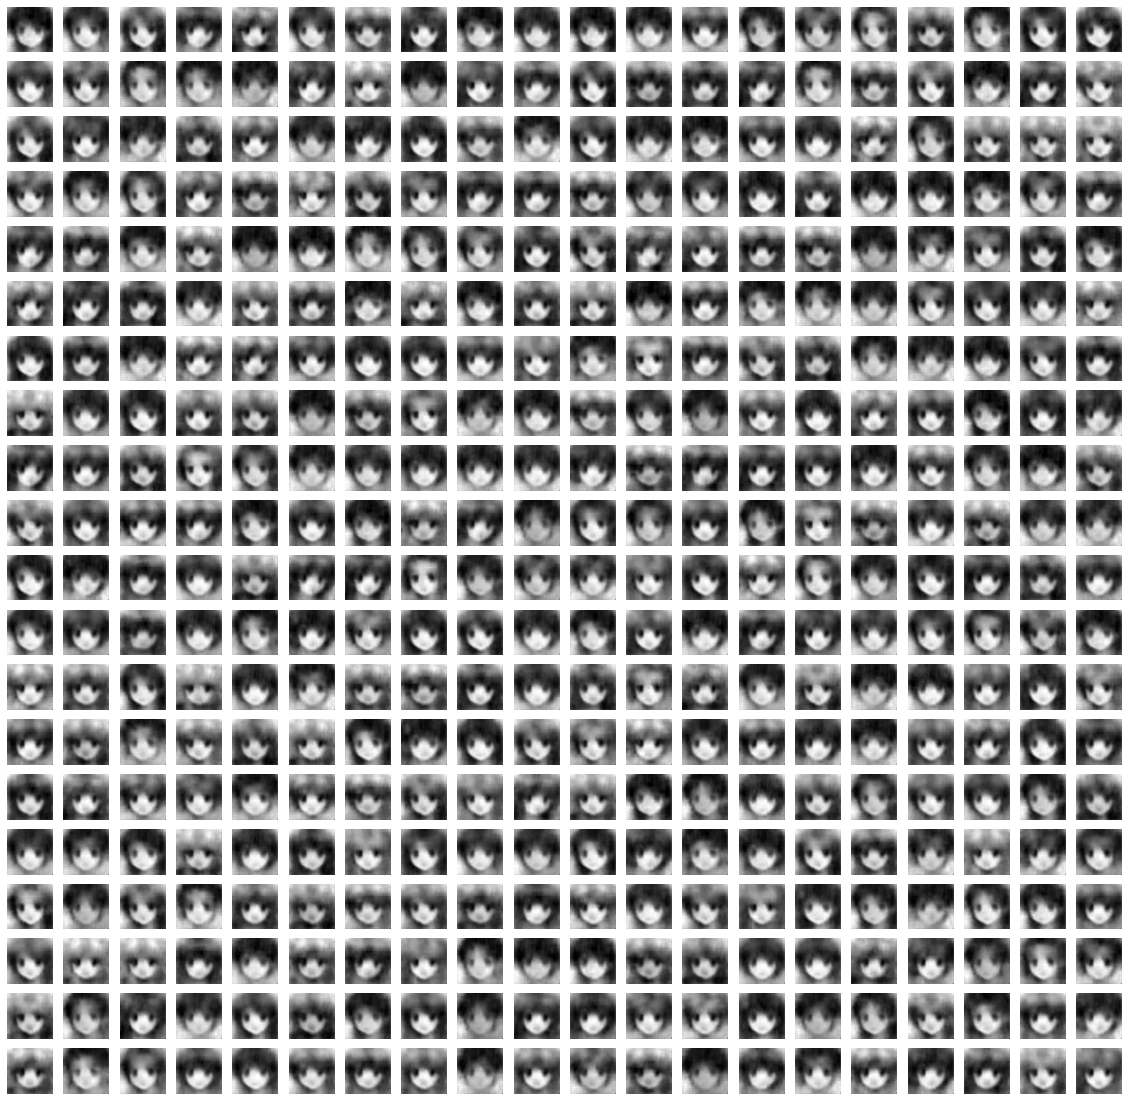

In [18]:
x1=np.random.uniform(-2,2,400)
x2=np.random.uniform(-3,3,400)
x3=np.random.uniform(-1.5,2,400)
x4=np.random.uniform(-1.,2,400)

fig  = plt.figure(figsize=(20,20))
for q in range(400):
  fig.add_subplot(20,20,q+1)
  y_pred=decoder_model.predict([[x1[q],x2[q],x3[q],x4[q]]]);
  plt.imshow(y_pred.reshape(56,56)*255,cmap='gray');
  plt.axis('off')